[Epoch 1] Loss: 314.5197


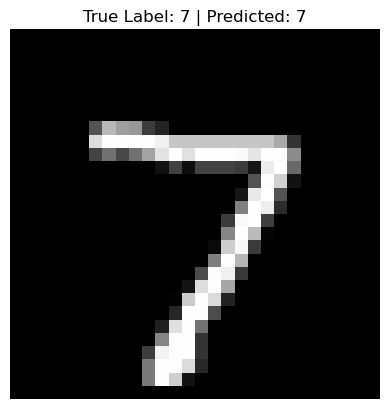

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# ✅ 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 1. MNIST 데이터 로딩 (keras)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# ✅ 2. PyTorch Tensor 변환 및 reshape
x_train_tensor = torch.tensor(x_train).unsqueeze(1)  # (N, 1, 28, 28)
x_test_tensor = torch.tensor(x_test).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ✅ 3. DataLoader 생성
batch_size = 128
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=batch_size)

# ✅ 4. DNN 모델 정의 (Softmax 제거됨)
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # ❌ Softmax 없음!
        return x

# ✅ 5. 모델 학습
model = DNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(1):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")

# ✅ 6. 예측 함수 정의 (정규화 포함)
def predict_number(image_tensor):
    image_tensor = transforms.Normalize((0.5,), (0.5,))(image_tensor)  # ✅ 정규화
    image_tensor = image_tensor.unsqueeze(0).to(device)  # (1, 1, 28, 28)
    model.eval()  # ✅ 평가 모드 설정
    with torch.no_grad():
        output = model(image_tensor)
        pred_label = torch.argmax(output).item()
    return pred_label

# ✅ 7. 테스트 이미지 시각화 및 예측
index = 0  # 예측할 이미지 번호
sample_image = x_test_tensor[index]
true_label = y_test[index]
predicted_label = predict_number(sample_image)

# ✅ 8. 결과 출력
plt.imshow(x_test[index], cmap='gray')
plt.title(f"True Label: {true_label} | Predicted: {predicted_label}")
plt.axis('off')
plt.show()
